# Introduction
Kindly make a copy(**File-> Save a copy in Drive**) of this notebook and rename it (xAutoML_2022_Algorithm_Selection_firstname_lastname.ipynb).

# Session objectives




*   Understanding the algorithm selection problem.
*   Practicing algorithm selection techniques.
*   Implementing various methods for the algorithm selection problem.



# Setup

In [1]:
# To import arff files, we install liac-arff
# Run this cell and restart runtime.
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=140e02aa4f076f42ef03bbf33de4143fee659c58fc228d4c5f0e5020b747c46a
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


In [2]:
import pandas as pd
import numpy as np
from scipy import stats

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
# import urllib.request


#
import arff
from collections import defaultdict
from typing import List, Tuple, Dict

# for ignoring the warnings massages.
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# List of homeworks


1. Calculate the single best and virtual best average [2 points]
2. Implement a regression medel per algorithm. [2 points]
3. Use k-fold cross validation. [2 point]
4. Implement hyprid regression model to compair each algorithm pairs.(optional) [2 points]

**P.S: for some of the above tasks, you may need to add more cells. please add all extra cells at the end of the notebook.**

# Single Best and Virtual Best Performance
As you learned in the lecture, we may evaluate portfolios in a variety of methods. In this case, we want to discover the single best and virtual best performance.

In [3]:
algos = []  # track individual algorithm performances
insts = []  # track individual instance performances
virtual_best=[]
single_best=[]

## Toy data
Let us apply these methods on the toy data!

### Apply PAR10

The **penalized average runtime score (PAR10)** measures the time required to run on all problem instances. If an instance was solved within a time budget less than the cutoff time, the actual runtime is taken. If the runtime exceeds the cutoff time, the runtime is pernalized.


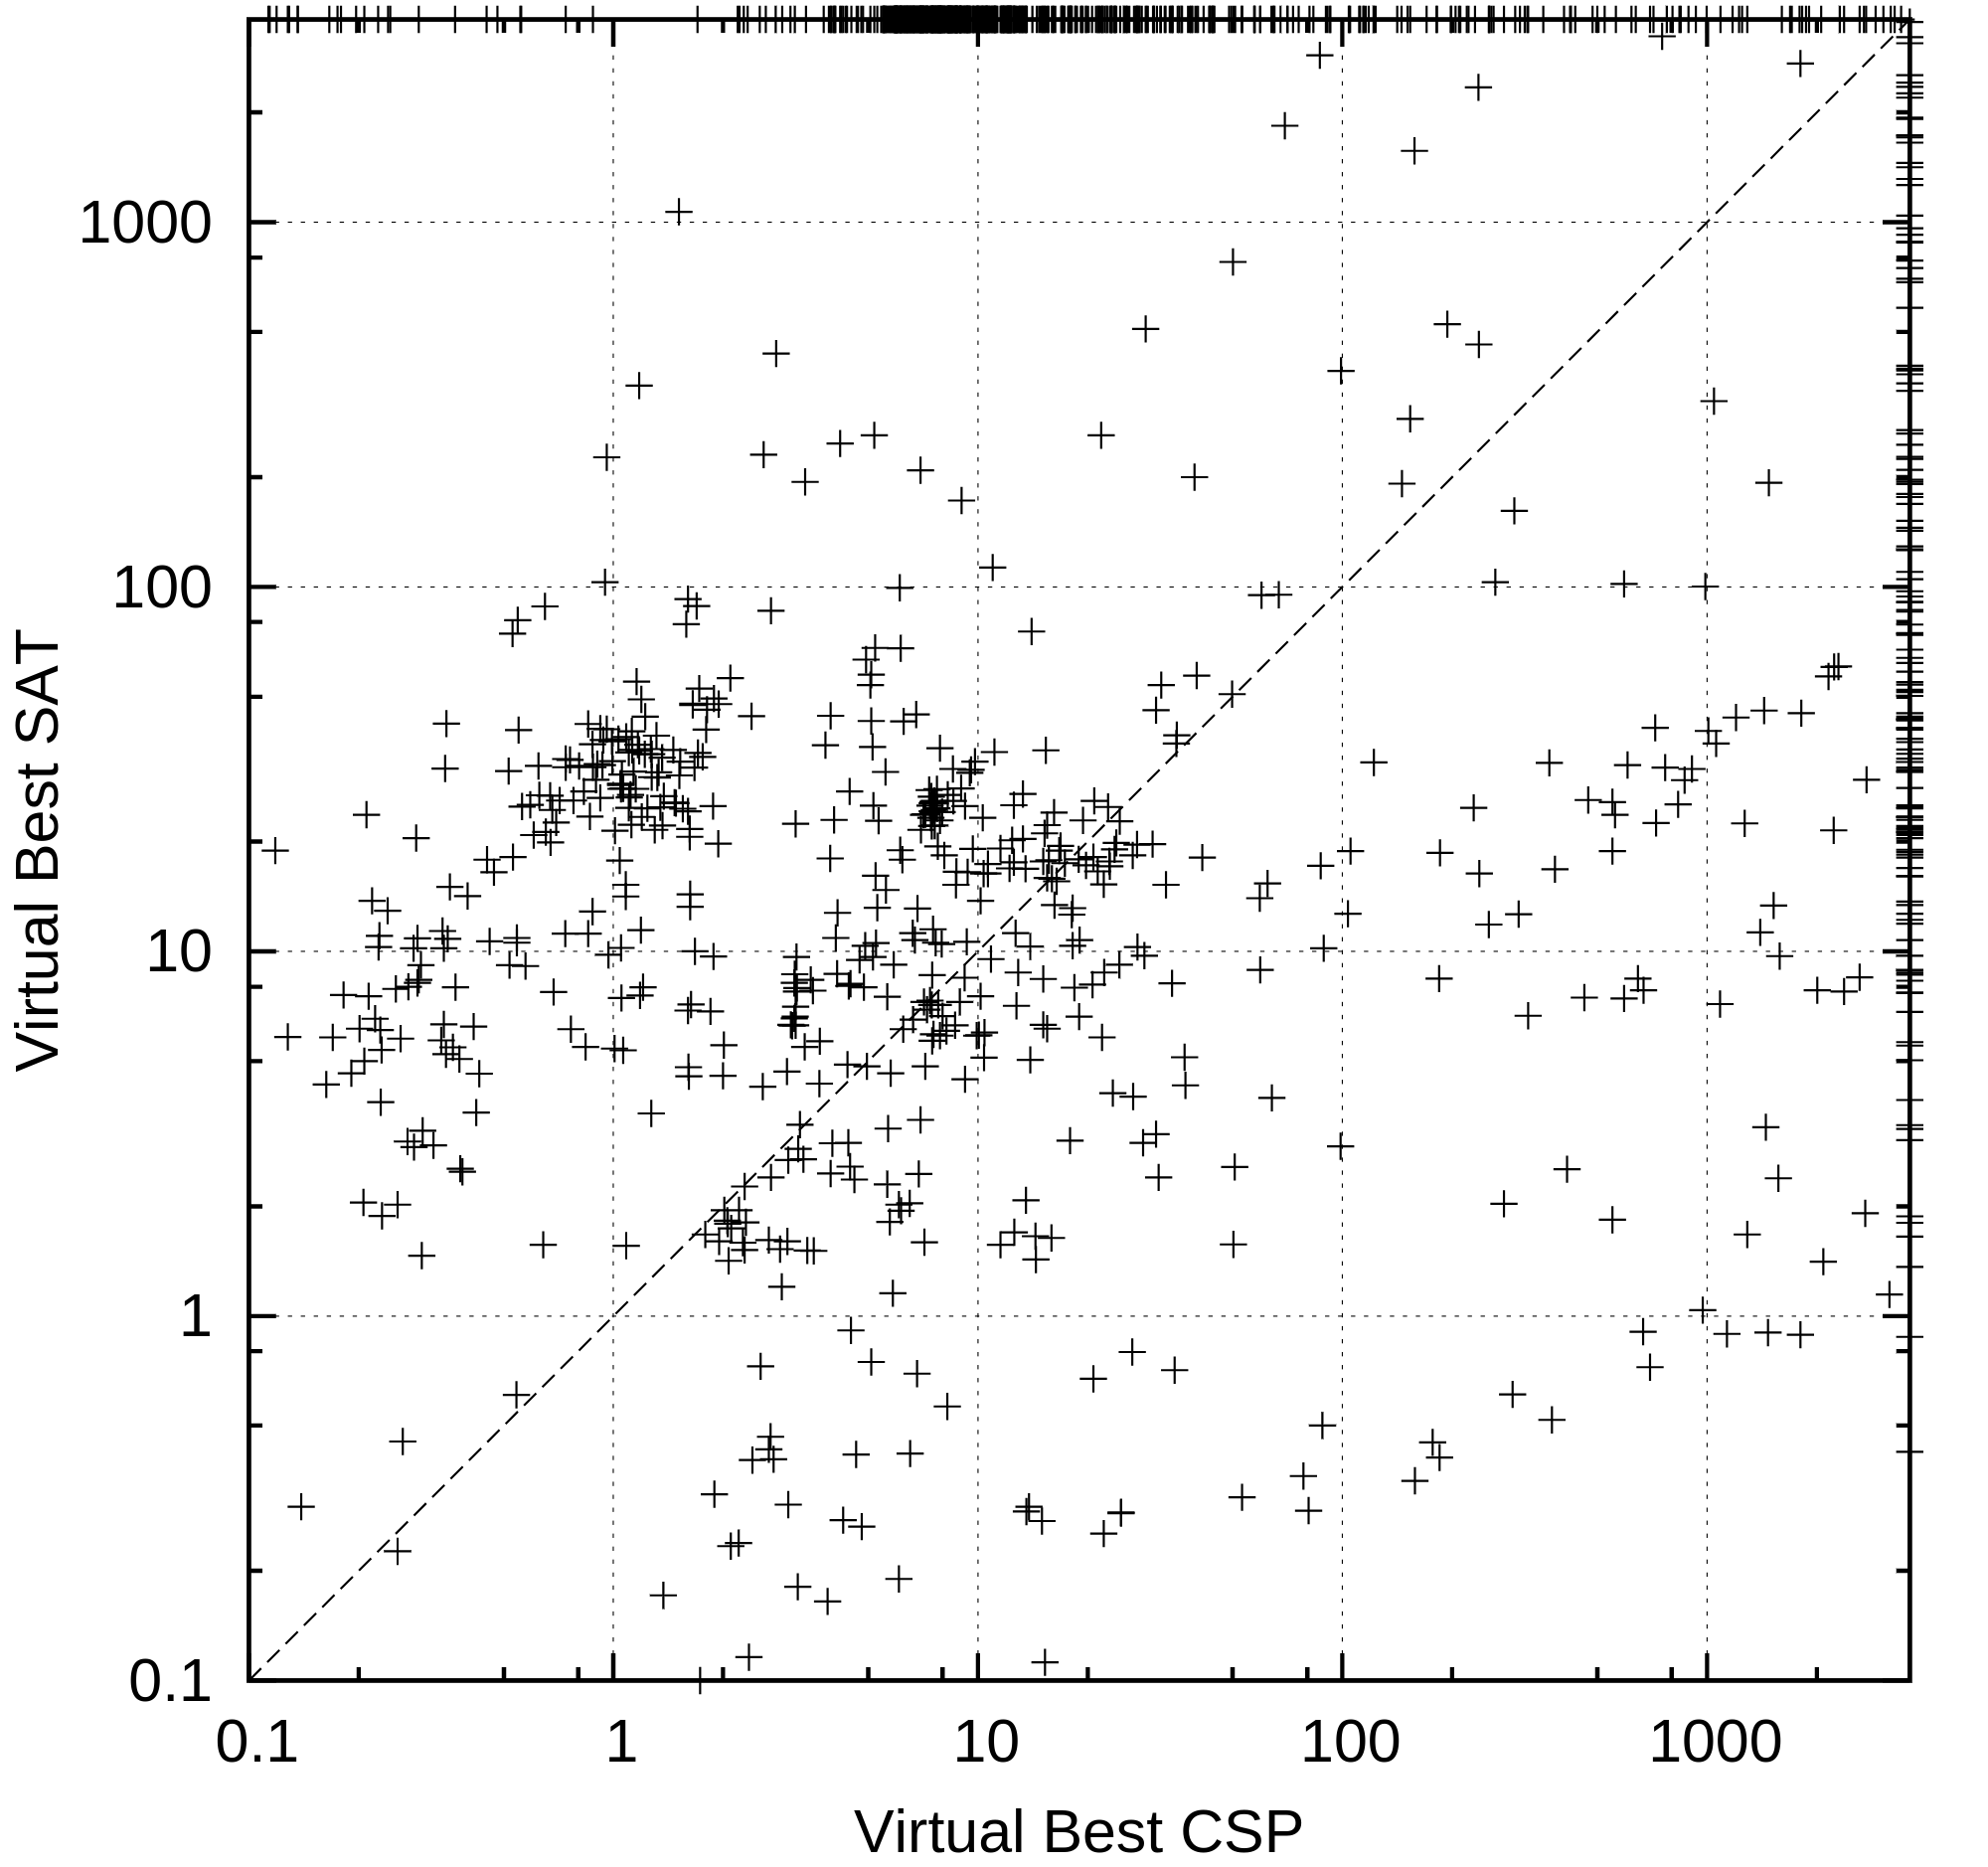

In [4]:
cutoff=4
par=2

In [5]:
# columns name: task, repetetion, algorithm, runtime, runstatus
data = [['a', 1., 'A', 1., 'ok'],
        ['a', 1., 'B', 3., 'ok'],

        ['b', 1., 'A', 2., 'ok'],
        ['b', 1., 'B', 1., 'ok'],

        ['c', 1., 'A', 3., 'ok'],
        ['c', 1., 'B', 1., 'ok'],

        ['d', 1., 'A', 1., 'ok'],
        ['d', 1., 'B', 3., 'ok'],

        ['e', 1., 'A', 1., 'ok'],
        ['e', 1., 'B', 4., 'timeout'],

        ['f', 1., 'A', 5., 'timeout'],  # even though a 5 is recorded as runtime value, the penalized value
        ['f', 1., 'B', 3., 'ok']]       # will be 4*2 instead of 5*2


In [6]:
# Convert the data into a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=['task', 'repetition', 'algorithm', 'runtime', 'runstatus'])

# Compute penalized runtime for each row
df['penalized_runtime'] = np.where(df['runstatus'] == 'ok',
                                   np.where(df['runtime'] <= cutoff, df['runtime'], cutoff * par),
                                   cutoff * par)

# Compute average penalized runtime for each algorithm
algos = df.groupby('algorithm')['penalized_runtime'].mean().to_dict()

# Compute virtual best runtime for each task
df_virtual_best = df.groupby('task')['penalized_runtime'].min().reset_index()
virtual_best = df_virtual_best['penalized_runtime'].mean()

print("Penalized average runtime for each algorithm:", algos)
print("Virtual best penalized average runtime:", virtual_best)

Penalized average runtime for each algorithm: {'A': 2.6666666666666665, 'B': 3.1666666666666665}
Virtual best penalized average runtime: 1.3333333333333333


In [7]:
A = (1+2+3+1+1+cutoff*par)/6
B = (3+1+1+3+cutoff*par+3)/6

In [9]:
# write your code here
single_best=algos['A' if A < B else 'B']
print("Single best is: ", single_best)
print("Virtual best is: ", virtual_best)

Single best is:  2.6666666666666665
Virtual best is:  1.3333333333333333


# Data collection

In [10]:
# Import algorithm_runs file
# download file from this URL: https://drive.google.com/file/d/194SLYwJS1_txFSmZbu6T_LPn1h1f1ssU/view?usp=sharing
# and upload it to current directory
arff_file = arff.load(open('./algorithm_runs.arff'))

In [11]:
# converting an arff file to a dataframe to make it easier to edit
algorithm_runs_df= pd.DataFrame(arff_file['data'])

In [12]:
# There is no title for the columns!
algorithm_runs_df

,0,1,2,3,4
0,./SAT11/application/rintanen/SATPlanning/block...,1.0,RestartSAT_B95,34.87970,ok
1,./SAT11/application/rintanen/SATPlanning/block...,1.0,glueminisat_2.2.5,34.73170,ok
2,./SAT11/application/rintanen/SATPlanning/block...,1.0,SAT09referencesolverprecosat_236,221.17700,ok
3,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackcir_minisat_2011-05-13_simp_,203.37500,ok
4,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackreferenceminisat_2.2.0,48.10370,ok
...,...,...,...,...,...
5395,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,minisathackminisat_psm_2011-04-01,3.64545,ok
5396,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,CryptoMiniSat_Strange-Night2-st_fixed_,15.88060,ok
5397,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,rcl_2011-04-01,4.09638,ok
5398,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,MPhaseSAT64_2011-05-14_fixed_,10.59340,ok


In [13]:
# Add name of columns to dataframe.
algorithm_runs_df.columns=["instance_id","repetition","algorithm", "runtime", "runstatus"]

In [14]:
# Check the 5 frist record of the dataframe.
algorithm_runs_df.head(5)

,instance_id,repetition,algorithm,runtime,runstatus
0,./SAT11/application/rintanen/SATPlanning/block...,1.0,RestartSAT_B95,34.8797,ok
1,./SAT11/application/rintanen/SATPlanning/block...,1.0,glueminisat_2.2.5,34.7317,ok
2,./SAT11/application/rintanen/SATPlanning/block...,1.0,SAT09referencesolverprecosat_236,221.1770,ok
3,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackcir_minisat_2011-05-13_simp_,203.3750,ok
4,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackreferenceminisat_2.2.0,48.1037,ok


In [15]:
algorithms = algorithm_runs_df.algorithm.unique()
algorithms

array(['RestartSAT_B95', 'glueminisat_2.2.5',
       'SAT09referencesolverprecosat_236',
       'minisathackcir_minisat_2011-05-13_simp_',
       'minisathackreferenceminisat_2.2.0',
       'minisathackEBMiniSAT_2011-03-02',
       'minisathackcontrasat_2011-03-02',
       'minisathackLR_GL_SHR_2011-03-02',
       'minisathackMiniSAT_2.2.0-agile-26',
       'SAT09referencesolverglucose_1.0', 'glucose_2', 'EBGlucose_1.0',
       'Lingeling_587f_fixed_', 'minisathackminisat_psm_2011-04-01',
       'CryptoMiniSat_Strange-Night2-st_fixed_', 'rcl_2011-04-01',
       'MPhaseSAT64_2011-05-14_fixed_', 'QuteRSat_2011-05-12_fixed_'],
      dtype=object)

In [16]:
algorithm_runs_df.instance_id.unique().shape[0]

300

In [17]:
# A brief description of the dataframe.
algorithm_runs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   instance_id  5400 non-null   object 
 1   repetition   5400 non-null   float64
 2   algorithm    5400 non-null   object 
 3   runtime      5400 non-null   float64
 4   runstatus    5400 non-null   object 
dtypes: float64(2), object(3)
memory usage: 211.1+ KB


In [18]:
algos = []  # track individual algorithm performances
insts = []  # track individual instance performances
virtual_best=[]
single_best=[]

# Apply PAR10

In [19]:
cutoff=5000
par=10

In [20]:
# Apply PAR10 to the dataframe
algorithm_runs_df["runtime"]=np.where((algorithm_runs_df.runtime>=cutoff),cutoff*par,algorithm_runs_df.runtime)

# Calculate the virtual best and the single best average [2 point]


## Virtual Best Performance [1 point]

In [24]:
#Your code start here

# Group by instance_id and compute the minimum runtime for each instance
virtual_best_per_instance = algorithm_runs_df.groupby('instance_id')['runtime'].min().reset_index()
virtual_best_per_instance.columns = ['instance_id', 'runtime_min']
print(virtual_best_per_instance.set_index('instance_id'))

#Your code end here

                                                    runtime_min
instance_id                                                    
./SAT02/industrial/aloul/Bart/bart17.shuffled.cnf      0.003998
./SAT02/industrial/aloul/Homer/homer14.shuffled...    71.343200
./SAT02/industrial/aloul/Homer/homer16.shuffled...   968.957000
./SAT02/industrial/aloul/Homer/homer17.shuffled...   238.870000
./SAT02/industrial/biere/dinphil/dp04s04.shuffl...     0.006998
...                                                         ...
SAT_RACE08/cnf/manol-pipe-c10nidw.cnf                132.277000
SAT_RACE08/cnf/manol-pipe-c6bidw_i.cnf                12.665100
SAT_RACE08/cnf/manol-pipe-f7nidw.cnf                  23.708400
SAT_RACE08/cnf/mizh-sha0-36-4.cnf                     28.073700
SAT_RACE08/cnf/velev-vliw-uns-4.0-9-i1.cnf           380.915000

[300 rows x 1 columns]


In [26]:
# Compute the average of these virtual best runtimes across all instances
virtual_best = virtual_best_per_instance['runtime_min'].mean()

print("\nvirtual best is", virtual_best)


virtual best is 8187.517818206667


## Single Best Performance [1 point]
Algorithm with the best performance across all datasets.

In [27]:
algorithm_runs_df

,instance_id,repetition,algorithm,runtime,runstatus
0,./SAT11/application/rintanen/SATPlanning/block...,1.0,RestartSAT_B95,34.87970,ok
1,./SAT11/application/rintanen/SATPlanning/block...,1.0,glueminisat_2.2.5,34.73170,ok
2,./SAT11/application/rintanen/SATPlanning/block...,1.0,SAT09referencesolverprecosat_236,221.17700,ok
3,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackcir_minisat_2011-05-13_simp_,203.37500,ok
4,./SAT11/application/rintanen/SATPlanning/block...,1.0,minisathackreferenceminisat_2.2.0,48.10370,ok
...,...,...,...,...,...
5395,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,minisathackminisat_psm_2011-04-01,3.64545,ok
5396,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,CryptoMiniSat_Strange-Night2-st_fixed_,15.88060,ok
5397,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,rcl_2011-04-01,4.09638,ok
5398,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,MPhaseSAT64_2011-05-14_fixed_,10.59340,ok


In [28]:
single_best_df = pd.DataFrame(columns=('Algo', 'min_run'))

# Group by algorithm and compute the average runtime for each algorithm
avg_runtimes = algorithm_runs_df.groupby('algorithm')['runtime'].mean().reset_index()

# Rename columns for consistency
avg_runtimes.columns = ['Algo', 'min_run']

# Append the data to single_best_df
single_best_df = single_best_df.append(avg_runtimes, ignore_index=True)

print(single_best_df)

                                       Algo       min_run
0    CryptoMiniSat_Strange-Night2-st_fixed_  15853.671929
1                             EBGlucose_1.0  17308.130607
2                     Lingeling_587f_fixed_  15726.297431
3             MPhaseSAT64_2011-05-14_fixed_  16922.547882
4                QuteRSat_2011-05-12_fixed_  16047.066959
5                            RestartSAT_B95  16844.812952
6           SAT09referencesolverglucose_1.0  17594.636020
7          SAT09referencesolverprecosat_236  16073.682570
8                                 glucose_2  14605.904256
9                         glueminisat_2.2.5  15306.457989
10          minisathackEBMiniSAT_2011-03-02  17692.243997
11          minisathackLR_GL_SHR_2011-03-02  18539.078243
12        minisathackMiniSAT_2.2.0-agile-26  18804.946174
13  minisathackcir_minisat_2011-05-13_simp_  16760.418941
14          minisathackcontrasat_2011-03-02  17275.754270
15        minisathackminisat_psm_2011-04-01  17552.609145
16        mini

In [29]:
single_best_df.min_run.min()

14605.904255913334

# Models for Individual Algorithms [2 points]
The lecture taught you about how individual regression models can be used for algorithm selection.
Fit a regression model per algorithm to the data. Use these models to predict the expected performances and select which algorithm should solve an instance, given its features. As regression model you can use anything available in sklearn (You are not required to adjust the hyperparameters of the chosen regressor).

In [30]:
# Reading meta-features of the instances
arff_file = arff.load(open('./feature_values.arff'))
features_df= pd.DataFrame(arff_file['data'])
cols = ['instance_id']
for i in range(features_df.shape[1] - 1):
    cols.append('feat_%d' % i)
features_df.columns = cols
features_df

,instance_id,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,...,feat_106,feat_107,feat_108,feat_109,feat_110,feat_111,feat_112,feat_113,feat_114,feat_115
0,./SAT11/application/rintanen/SATPlanning/block...,1.0,733825.0,13169160.0,587927.0,10311015.0,0.2482,0.2772,0.0570,0.7896,...,0.0000,0.0,0.0,0.0,32.2696,0.0000,1.9702,0.0000,0.1952,0.2760
1,./SAT07/industrial/jarvisalo/eq.atree.braun.12...,1.0,1694.0,5726.0,1165.0,4834.0,0.4541,0.1845,0.2410,0.3448,...,0.0448,244.0,229.0,258.0,0.4399,0.2713,0.8459,0.0201,0.2252,0.9708
2,./SAT11/application/manthey/traffic/traffic_b_...,1.0,26061.0,742909.0,25957.0,742878.0,0.0040,0.0000,0.0349,0.0538,...,0.0096,8640.0,8550.0,8640.0,1.5384,1.0493,0.9624,0.0080,0.2681,0.4539
3,./SAT11/application/fuhs/slp-synthesis-AES/slp...,1.0,40286.0,134663.0,15806.0,87498.0,1.5488,0.5390,0.1806,0.4287,...,0.0121,4397.0,4314.0,4433.0,0.1417,0.2514,0.8832,0.0077,0.0717,0.2552
4,./SAT11/application/jarvisalo/smtqfbv-aigs/smt...,1.0,266663.0,768347.0,47208.0,235550.0,4.6487,2.2619,0.2004,0.4843,...,0.0058,11604.5,11477.0,11611.0,0.4754,0.6919,0.8881,0.0112,0.1621,0.3650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,SAT_RACE08/cnf/manol-pipe-f7nidw.cnf,1.0,310434.0,923497.0,45777.0,364855.0,5.7814,1.5311,0.1255,0.3682,...,0.0048,12604.0,12513.0,12604.0,0.3763,0.2117,0.8978,0.0056,0.0253,0.1168
296,./SAT11/application/leberre/2dimensionalstripp...,1.0,6664.0,89966.0,5924.0,88818.0,0.1249,0.0129,0.0667,0.7744,...,0.5591,2545.0,0.0,2554.0,1.9984,0.4883,1.0376,0.1286,0.3045,0.6691
297,./SAT11/application/kullmann/AES/Benchmarks/12...,1.0,8080.0,96704.0,7616.0,95280.0,0.0609,0.0149,0.0799,0.3535,...,0.0165,1010.0,993.0,1031.0,0.1238,0.3206,0.7206,0.0101,0.1595,0.2680
298,./SAT07/industrial/anbulagan/hard-sat/partial-...,1.0,298900.0,1409628.0,150440.0,868292.0,0.9868,0.6234,0.1733,0.3881,...,0.0000,0.0,0.0,0.0,2.7114,0.0000,1.1493,0.0000,0.1809,0.7234


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Impute missing values in the feature matrix
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Extract features and target for each algorithm and fit a model
models = {}
for algo in algorithms:
    y = algorithm_runs_df[algorithm_runs_df['algorithm'] == algo]['runtime']

    model = LinearRegression()
    model.fit(X_imputed, y)
    models[algo] = model

# Predict the expected runtime for each algorithm on each instance
per_algo_df = pd.DataFrame(index=features_df['instance_id'])
for algo, model in models.items():
    per_algo_df[algo] = model.predict(X_imputed)

# Select the algorithm with the minimum predicted runtime for each instance
per_algo_df['selected'] = per_algo_df.min(axis=1)

print(per_algo_df)

                                                    RestartSAT_B95  \
instance_id                                                          
./SAT11/application/rintanen/SATPlanning/blocks...    -9279.289322   
./SAT07/industrial/jarvisalo/eq.atree.braun.12....    24494.885833   
./SAT11/application/manthey/traffic/traffic_b_u...   -11846.618328   
./SAT11/application/fuhs/slp-synthesis-AES/slp-...    51816.021041   
./SAT11/application/jarvisalo/smtqfbv-aigs/smtl...    -1695.480342   
...                                                            ...   
SAT_RACE08/cnf/manol-pipe-f7nidw.cnf                   9698.687787   
./SAT11/application/leberre/2dimensionalstrippa...     8952.218441   
./SAT11/application/kullmann/AES/Benchmarks/128...    54277.820406   
./SAT07/industrial/anbulagan/hard-sat/partial-1...    32731.213340   
./SAT11/application/jarvisalo/smtqfbv-aigs/smtl...     5523.134071   

                                                    glueminisat_2.2.5  \
instance_id     

# 5 fold cross validation [2 point]
For better evaluation, you can use 5 fold cross validation. You are free to choose how to implement it! Please leave a comment with your code!

In [34]:
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

kf = KFold(n_splits=5, random_state=None, shuffle=True)

# Extract features from the features_df
X = features_df.drop(columns=['instance_id']).values

# Dictionary to store the mean absolute errors for each algorithm
mae_per_algo = {algo: [] for algo in algorithms}

# Iterate over each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]

    # Impute missing values in the training and test sets
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)

    # For each algorithm, train a model and predict on the test set
    for algo in algorithms:
        algo_train_indices = algorithm_runs_df.iloc[train_index][algorithm_runs_df['algorithm'] == algo].index
        algo_test_indices = algorithm_runs_df.iloc[test_index][algorithm_runs_df['algorithm'] == algo].index

        y_train = algorithm_runs_df.loc[algo_train_indices]['runtime']
        y_test = algorithm_runs_df.loc[algo_test_indices]['runtime']

        model = LinearRegression()
        model.fit(X_train_imputed[algo_train_indices], y_train)

        y_pred = model.predict(X_test_imputed[algo_test_indices])

        mae = mean_absolute_error(y_test, y_pred)
        mae_per_algo[algo].append(mae)

# Calculate the average MAE over the 5 folds for each algorithm
avg_mae_per_algo = {algo: sum(maes)/len(maes) for algo, maes in mae_per_algo.items()}

print(avg_mae_per_algo)

IndexError: ignored

Calculate the average time if you used the predicted algorithm with the 300 instances. Compare the result to the virtual best and single best average.

In [ ]:
# Your code start here
#
# Your code end here

# Hybrid Models (optional) [1 points]
Further you have learned about hybrid models. Implement pairwise classification models to vote on which algorithm should be chosen to solve an instance. Similar to the prior exercise you can use sklearn to choose any classifier you want to use.

Note: We encourage you to apply your implementations to the previous data. However, this might require parameter tuning or more efforts to train a meaningful selector.

In [ ]:
# Your code start here
#
# Your code end here

# Share your thoughts and provide us feedback regarding to this notebook.(Optional)


Write your feedback here:

# <font color='green'> Finished! </font>



